In [7]:
import os, sys
sys.path.append('../')
import  re
sys.path.append(os.path.curdir)
sys.path.append(sys.argv[0])
import numpy as np
import analysisPlot

import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:

#Name1 -- Name2\tIndex1 -- Index2\tPredction1 -- Prediction2\tprobDIff
fileIn = '../tmpOut/diffMat.txt'
subSep = ' -- '

oriIndex = 0

proteinStr = 'GAVLIPFYWSTCMNQDEKRHXBJOUZ'
dnaStr = 'AGCT'
rnaStr = 'AGCU'

mutationDict = {} # position:ori:mutation
keySet = set()
with open(fileIn) as FID:     
    rowList = []
    rowOldInd = None
    for line in FID:
        if line.startswith('#'):
            continue
        eles = line.strip().split('\t')
        name1, name2 = eles[0].split(subSep)
        index1, index2 = eles[1].split(subSep)
        index1 = int(index1)
        index2 = int(index2)
        out1, out2 = eles[2].split(subSep)
        probDiff = float(eles[3])
        if index1 == oriIndex:
            position, oriRes, mutatedRes = re.findall('(\d+)_(\w)-(\w)',name2.split('###')[1])[0]
            position = int(position)
            if not position in mutationDict:
                mutationDict[position] = {}
            if not oriRes in mutationDict[position]:
                mutationDict[position][oriRes] = {}
            mutationDict[position][oriRes][mutatedRes] = probDiff
            keySet.add(oriRes.upper())
            keySet.add(mutatedRes.upper())

if 'X' in keySet:
    keySet.remove('X')
if len(keySet) == 4:
    if 'U' in keySet:
        tempStr = rnaStr
    else:
        tempStr = dnaStr
else:
    tempStr = proteinStr

outMat = np.zeros([len(tempStr),len(list(mutationDict.keys()))])        
outStrDict = {'ori':'Seq:\t'}
for res in tempStr:
    outStrDict[res] = '%s:\t' %res
for position in np.sort(list(mutationDict.keys())):
    oriRes = list(mutationDict[position].keys())[0]
    outStrDict['ori'] += '%s\t' %oriRes
    for i,mutatedRes in enumerate(tempStr):
        if mutatedRes in mutationDict[position][oriRes]:
            outStrDict[mutatedRes] += '%.6e\t' %(mutationDict[position][oriRes][mutatedRes])
            outMat[i,position] = mutationDict[position][oriRes][mutatedRes]
        else:
            outStrDict[mutatedRes] += '0\t'
            outMat[i,position] = 0


In [5]:
#text output 
print(outStrDict['ori'])
for res in tempStr:
    print(outStrDict[res])


Seq:	G	T	T	G	T	T	G	C	A	G	T	T	G	G	A	T	A	T	A	G	A	C	C	A	C	G	G	A	G	A	
A:	-4.900000e-05	-1.100000e-05	-3.000000e-05	1.400000e-05	5.000000e-06	-2.900000e-05	2.300000e-05	-2.000000e-05	0	-9.100000e-05	2.000000e-05	8.000000e-06	-4.700000e-05	-7.000000e-06	0	-1.190000e-04	0	-3.800000e-04	0	-4.500000e-05	0	-1.450000e-04	-3.900000e-05	0	1.300000e-05	-3.200000e-05	1.200000e-05	0	2.300000e-05	0	
G:	0	0.000000e+00	-4.700000e-05	0	-4.900000e-05	-3.150000e-04	0	6.000000e-06	2.400000e-05	0	2.000000e-05	-3.600000e-05	0	0	-2.840000e-04	-1.800000e-05	-1.740000e-04	-4.980000e-04	-2.680000e-04	0	-1.010000e-04	-7.900000e-05	3.000000e-06	2.400000e-05	2.200000e-05	0	0	-2.400000e-05	0	6.000000e-06	
C:	-4.000000e-06	7.000000e-06	7.000000e-06	-1.150000e-04	7.000000e-06	5.000000e-06	1.300000e-05	0	2.400000e-05	-4.500000e-05	-6.000000e-06	-2.200000e-05	-1.000000e-04	-2.000000e-05	-1.363000e-03	-3.245000e-03	-2.500000e-05	-1.020000e-04	-1.137000e-03	2.100000e-05	0.000000e+00	0	0	-3.100000e-05	0	-1.130000e-04	1.90000

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15));

# labels_plot = ax1.imshow(y_label,cmap=plt.get_cmap('Set1'))
labels_plot = ax1.imshow(y_label_for_plotting,cmap=plt.get_cmap('Set1'))

ax1.set_aspect(0.3)
ax1.set_axis_off()
cb = plt.colorbar(labels_plot)
labels = np.arange(0,6,1)
loc = labels
cb.set_ticks(loc)
cb.set_ticklabels(list(range(6)))
cb.set_label('Original Class')
att_plot = ax2.imshow(att2_out, aspect='auto',cmap='coolwarm')
ax2.yaxis.set_visible(False)
plt.tight_layout(pad=37, w_pad=0.5, h_pad=1.0)
plt.xlabel('Normalized Attention Values')
plt.title('The relation between attention values and class')
plt.show()

In [20]:
minVal = np.min([-1*np.abs(outMat.min()), -1*np.abs(outMat.max())])
maxVal = np.max([np.abs(outMat.min()), np.abs(outMat.max())])

In [62]:
from importlib import reload 
reload(analysisPlot)

<module 'analysisPlot' from '..\\analysisPlot.py'>

In [49]:
xTickLabels = outStrDict['ori'].split('\t')[1:-1]
yTickLabels = list(tempStr)

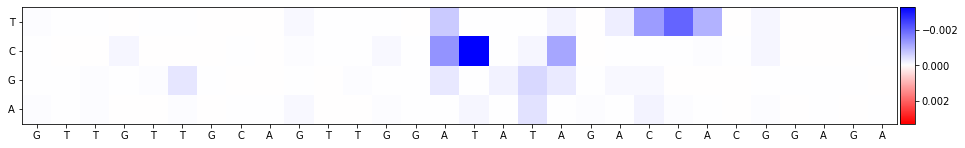

In [67]:
analysisPlot.showMatWithVal(outMat,showText=False,vmin=None,norm = mpl.colors.Normalize(vmin=minVal,vmax=maxVal),cmapName='bwr',
                            xtickLabels=xTickLabels,ytickLabels=yTickLabels,driverCaxSize=0.2)